In [30]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from scipy.stats import binom_test
from matplotlib.markers import TICKDOWN
from matplotlib import rcParams
import datetime
from scipy.stats import norm, kstest, sem, ttest_ind
from numpy.polynomial import polynomial

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.cell_roi import OverlapCounterROI

In [31]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/"
data_dir = "P:/John/analyzed_archived/scnn1a-tg3-cre/PPR checkpoints/scnn1a-ppr/"
master_csv = data_dir + 'scnn1a-ppr.csv'
###################################
# Process paired-pulse ratio data
#    - IPIs are shuffled, open <slice>_<loc>shuffle.txt for IPI order
#    - extract Amplitude, half_width, latency for pulse 1 and pulse 2 for each ROI
#    - ROIs are in order (in file "<slice>_barrel_rois.dat" for each date subdir):
#          -  medial -> lateral if available
#          - otherwise, in some order that preserves neighbors (1,2 are neighbors and 2,3 are neighbors)
#    - which barrel is home barrel (stimulated) is recorded in master csv scnn1a-ppr.csv for each loc
###################################
enable_photoZ_interact = True
initialize_photoZ = True
disable_trace_export = True  # if True, don't export traces, only save arrays

snr_cutoff_signal = 0
amp_cutoff = 2

In [32]:
# set up PhotoZ (open it manually)
aPhz = AutoPhotoZ(data_dir=data_dir)
if initialize_photoZ and enable_photoZ_interact:
    aPhz.prepare_photoZ()
    # normalization needs to be off since we are saving arrays
    aPhz.click_normalize_2_array_max()

KeyboardInterrupt: 

In [ ]:
# load master csv file for metadata
master_df = pd.read_csv(master_csv)
master_df = pd.DataFrame(master_df)
master_df

,Date,Slice_Loc,Medial Dir,Stim Layer,Caudal/Rostral,Home Barrel
0,12/8/2023,3_2,up,L2/3,Caudal,2
1,12/8/2023,4_1,NaN,L4,Rostral,2
2,12/8/2023,5_1,NaN,L4,Rostral,1
3,12/8/2023,5_2,NaN,L4,Rostral,2
4,12/8/2023,6_1,NaN,L4,NaN,1
5,12/8/2023,6_2,NaN,L4,NaN,2
6,12/13/2023,1_4,NaN,L2/3,Rostral,1
7,12/13/2023,2_1,NaN,L4,Rostral,1
8,12/13/2023,3_1,NaN,L4,Caudal,2
9,12/13/2023,3_2,NaN,L2/3,Caudal,2


In [ ]:
def get_shuffle_filename(slic, loc):
    return str(slic) + "_" + str(loc) + "shuffle.txt"

def get_barrel_roi_filename(slic):
    return str(slic) + "_barrel_rois.dat"

# locate all files
data_map = {}
for subdir, dirs, files in os.walk(data_dir):
    if 'hidden' in subdir:
        continue
    if not ('dic' in dirs and 'selected_zda' in dirs):
        continue
    print("\n", subdir)
    dic_dir = subdir + "/dic/"
    selected_zda_dir = subdir + "/selected_zda/"
    data_map[subdir] = {}
    for zda_file in os.listdir(selected_zda_dir):
        if zda_file.endswith('.zda'):
            slr_id = zda_file.split('.')[0]
            slic_id, loc_id, rec_id = [int(x) for x in slr_id.split("_")]
            print(slic_id, loc_id, rec_id)
            if slic_id not in data_map[subdir]:
                # find ROI file and index it
                data_map[subdir][slic_id] = {'roi_file': subdir + "/" + get_barrel_roi_filename(slic_id)}
            if loc_id not in data_map[subdir][slic_id]:
                # find shuffle file and index it
                data_map[subdir][slic_id][loc_id] = {'zda_files': [],
                                                     'shuffle_file': subdir + "/" +  get_shuffle_filename(slic_id, loc_id)}
            data_map[subdir][slic_id][loc_id]['zda_files'].append(selected_zda_dir + "/" + zda_file)  # appends in ascending order


 P:/John/analyzed_archived/scnn1a-tg3-cre/PPR checkpoints/scnn1a-ppr/12-08-23
3 2 2
3 2 3
3 2 4
3 2 5
3 2 6
3 2 7
3 2 8
3 2 9
3 2 10
3 2 11
3 2 12
3 2 13
3 2 14
3 2 15
3 2 16
3 2 17
4 1 1
4 1 2
4 1 3
4 1 4
4 1 5
4 1 6
4 1 7
4 1 8
4 1 9
4 1 10
4 1 11
4 1 12
4 1 13
4 1 14
4 1 15
4 1 16
5 1 2
5 1 3
5 1 4
5 1 5
5 1 6
5 1 7
5 1 8
5 1 9
5 1 10
5 1 11
5 1 12
5 1 13
5 1 14
5 1 15
5 1 16
5 1 17
5 2 2
5 2 3
5 2 4
5 2 5
5 2 6
5 2 7
5 2 8
5 2 9
5 2 10
5 2 11
5 2 12
5 2 13
5 2 14
5 2 15
5 2 16
5 2 17
6 1 4
6 1 5
6 1 6
6 1 7
6 1 8
6 1 9
6 1 10
6 1 11
6 1 12
6 1 13
6 1 14
6 1 15
6 1 16
6 1 17
6 1 18
6 1 19
6 2 1
6 2 2
6 2 3
6 2 4
6 2 5
6 2 6
6 2 7
6 2 8
6 2 9
6 2 10
6 2 11
6 2 12
6 2 13
6 2 14
6 2 15
6 2 16

 P:/John/analyzed_archived/scnn1a-tg3-cre/PPR checkpoints/scnn1a-ppr/12-13-23
1 4 2
1 4 3
1 4 4
1 4 5
1 4 6
1 4 7
1 4 8
1 4 9
1 4 10
1 4 11
1 4 12
1 4 13
1 4 14
1 4 15
1 4 16
1 4 17
2 1 1
2 1 2
2 1 3
2 1 4
2 1 5
2 1 6
2 1 7
2 1 8
2 1 9
2 1 10
2 1 11
2 1 12
2 1 13
2 1 14
2 1 15
2 1 16
3 1 2
3 1 3

In [ ]:
# go through the IPIs in their shuffled order (ascending recordings) 
# and extract Amplitude, half_width, latency for pulse 1 and pulse 2 for each ROI
copy_enable_photoZ_interact = enable_photoZ_interact
enable_photoZ_interact = not disable_trace_export

for subdir in data_map:
    aPhz = AutoPhotoZ(data_dir=subdir)
    print(subdir)
    for slic_id in data_map[subdir]:

        # open roi_file for whole slice
        if enable_photoZ_interact:
            roi_file = data_map[subdir][slic_id]['roi_file']
            aPhz.select_roi_tab()
            aPhz.open_roi_file(roi_file)

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            ipi_file = data_map[subdir][slic_id][loc_id]['shuffle_file']
            with open(ipi_file, 'r') as f:
                lines = f.readlines() 
            ipi_order = [int(x) for x in lines]
            # open zda files in order
            i_ipi = -1
            for zda_file in data_map[subdir][slic_id][loc_id]['zda_files']:
                if enable_photoZ_interact:
                    aPhz.open_zda_file(zda_file)
                i_ipi += 1
                try:
                    ipi = ipi_order[i_ipi]
                except Exception as e:
                    print(e)
                    print("Not enough IPIs for how many recordings we have! Last IPI:", ipi, "Check", subdir)
                print(slic_id, loc_id, "IPI:", ipi, "ms for recording", zda_file.split("/")[-1])
                
                for i_pulse in [1, 2]:
                    if enable_photoZ_interact:
                        measure_window_start = 96 + (i_pulse - 1) * ipi * 2
                        aPhz.set_measure_window(measure_window_start, None)

                        # change polynomial skip window too to match measure window
                        aPhz.set_polynomial_skip_window(measure_window_start)

                    # take Amplitude, half_width, latency and label which pulse
                    # save SNR values from PhotoZ
                    snr_filename = subdir + "/" + "SNR_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(i_pulse) + ".dat"
                    if enable_photoZ_interact:
                        aPhz.select_SNR_trace_value()
                        aPhz.save_trace_values(snr_filename)

                    # save half-width values from PhotoZ
                    hw_filename = subdir + "/" + "hw_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(i_pulse) + ".dat" 
                    if enable_photoZ_interact:
                        aPhz.select_half_width_trace_value()
                        aPhz.save_trace_values(hw_filename)

                    # save amp values from PhotoZ
                    amp_filename = subdir + "/" + "amp_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(i_pulse) + ".dat"
                    if enable_photoZ_interact:
                        aPhz.select_maxamp_trace_value()
                        aPhz.save_trace_values(amp_filename)
                        
                    # save latency values from PhotoZ
                    lat_filename = subdir + "/" + "lat_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(i_pulse) + ".dat"
                    if enable_photoZ_interact:
                        aPhz.select_latency_trace_value()
                        aPhz.save_trace_values(lat_filename)


                    if ipi not in data_map[subdir][slic_id][loc_id]:
                        data_map[subdir][slic_id][loc_id][ipi] = {}
                    data_map[subdir][slic_id][loc_id][ipi][i_pulse] = {'amp': amp_filename,
                                                                       'hw': hw_filename,
                                                                       'snr': snr_filename,
                                                                       'lat': lat_filename}
            if i_ipi < len(ipi_order) - 1:
                print("Not enough recordings for how many IPIs we have! Last IPI:", ipi, "Check", subdir)
enable_photoZ_interact = copy_enable_photoZ_interact  

P:/John/analyzed_archived/scnn1a-tg3-cre/PPR checkpoints/scnn1a-ppr/12-08-23
3 2 IPI: 10 ms for recording 03_02_02.zda
3 2 IPI: 20 ms for recording 03_02_03.zda
3 2 IPI: 30 ms for recording 03_02_04.zda
3 2 IPI: 40 ms for recording 03_02_05.zda
3 2 IPI: 50 ms for recording 03_02_06.zda
3 2 IPI: 60 ms for recording 03_02_07.zda
3 2 IPI: 70 ms for recording 03_02_08.zda
3 2 IPI: 80 ms for recording 03_02_09.zda
3 2 IPI: 90 ms for recording 03_02_10.zda
3 2 IPI: 100 ms for recording 03_02_11.zda
3 2 IPI: 110 ms for recording 03_02_12.zda
3 2 IPI: 120 ms for recording 03_02_13.zda
3 2 IPI: 130 ms for recording 03_02_14.zda
3 2 IPI: 140 ms for recording 03_02_15.zda
3 2 IPI: 150 ms for recording 03_02_16.zda
3 2 IPI: 5 ms for recording 03_02_17.zda
4 1 IPI: 5 ms for recording 04_01_01.zda
4 1 IPI: 10 ms for recording 04_01_02.zda
4 1 IPI: 20 ms for recording 04_01_03.zda
4 1 IPI: 30 ms for recording 04_01_04.zda
4 1 IPI: 40 ms for recording 04_01_05.zda
4 1 IPI: 50 ms for recording 04_01_06

In [ ]:
# Also extract actual pulse admin times for pulse 1 and pulse 2
if enable_photoZ_interact:
    pa.alert("Make sure the only trace selected is analog input from stimulator")
latency_selected =  False
for subdir in data_map:
    aPhz = AutoPhotoZ(data_dir=subdir)
    if not latency_selected and enable_photoZ_interact:
        latency_selected = True
        aPhz.select_latency_trace_value()
    print(subdir)
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            ipi_file = data_map[subdir][slic_id][loc_id]['shuffle_file']
            with open(ipi_file, 'r') as f:
                lines = f.readlines() 
            ipi_order = [int(x) for x in lines]
            # open zda files in order
            i_ipi = -1
            for zda_file in data_map[subdir][slic_id][loc_id]['zda_files']:
                if enable_photoZ_interact:
                    aPhz.open_zda_file(zda_file)
                i_ipi += 1
                try:
                    ipi = ipi_order[i_ipi]
                except Exception as e:
                    print(e)
                    print("Not enough IPIs for how many recordings we have! Last IPI:", ipi, "Check", subdir)
                print(slic_id, loc_id, "IPI:", ipi, "ms for recording", zda_file.split("/")[-1])
                
                for i_pulse in [1, 2]:
                    if enable_photoZ_interact:
                        measure_window_start = 96 + (i_pulse - 1) * ipi * 2
                        aPhz.set_measure_window(measure_window_start, None)

                        # change polynomial skip window too to match measure window
                        aPhz.set_polynomial_skip_window(measure_window_start)
                    
                    # save pulse admin times
                    pa_filename = subdir + "/" + "pa_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(i_pulse) + ".dat"
                    data_map[subdir][slic_id][loc_id][ipi][i_pulse]['pa'] = pa_filename

                    if enable_photoZ_interact:
                        aPhz.save_trace_values(pa_filename)
                        print("\t Saved file", pa_filename)

P:/John/analyzed_archived/scnn1a-tg3-cre/PPR checkpoints/scnn1a-ppr/12-08-23
3 2 IPI: 10 ms for recording 03_02_02.zda
3 2 IPI: 20 ms for recording 03_02_03.zda
3 2 IPI: 30 ms for recording 03_02_04.zda
3 2 IPI: 40 ms for recording 03_02_05.zda
3 2 IPI: 50 ms for recording 03_02_06.zda
3 2 IPI: 60 ms for recording 03_02_07.zda
3 2 IPI: 70 ms for recording 03_02_08.zda
3 2 IPI: 80 ms for recording 03_02_09.zda
3 2 IPI: 90 ms for recording 03_02_10.zda
3 2 IPI: 100 ms for recording 03_02_11.zda
3 2 IPI: 110 ms for recording 03_02_12.zda
3 2 IPI: 120 ms for recording 03_02_13.zda
3 2 IPI: 130 ms for recording 03_02_14.zda
3 2 IPI: 140 ms for recording 03_02_15.zda
3 2 IPI: 150 ms for recording 03_02_16.zda
3 2 IPI: 5 ms for recording 03_02_17.zda
4 1 IPI: 5 ms for recording 04_01_01.zda
4 1 IPI: 10 ms for recording 04_01_02.zda
4 1 IPI: 20 ms for recording 04_01_03.zda
4 1 IPI: 30 ms for recording 04_01_04.zda
4 1 IPI: 40 ms for recording 04_01_05.zda
4 1 IPI: 50 ms for recording 04_01_06

In [ ]:
# load all these amp, hw, snr, lat into a dataframe
def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['ROI',  'Value'])
    return data_arr

snr_dfs = []
for subdir in data_map:
    
    # extract date from subdir so we can look up metadata from master_df
    date = subdir.split("/")[-1].split('-')
    date = [int(x) for x in date]
    date[-1] += 2000
    date = "/".join([str(x) for x in date])
    metadata_date = master_df[master_df['Date'] == date]
    
    for slic_id in data_map[subdir]:
        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)
            metadata = metadata_date[metadata_date['Slice_Loc'] == slic_loc_id]
            medial_dir = metadata['Medial Dir'].item()
            stim_layer = metadata['Stim Layer'].item()
            caudal_rostral = metadata['Caudal/Rostral'].item()
            home_barrel = int(metadata['Home Barrel'].item())

            for ipi in data_map[subdir][slic_id][loc_id]:
                if type(ipi) == str:
                    continue
                for i_pulse in data_map[subdir][slic_id][loc_id][ipi]:
                    dm = data_map[subdir][slic_id][loc_id][ipi][i_pulse]
                    
                    try:
                        amp = read_dat_trace_file(dm['amp'])
                        hw = read_dat_trace_file(dm['hw'])
                        snr = read_dat_trace_file(dm['snr'])
                        lat = read_dat_trace_file(dm['lat'])
                        actual_stim = read_dat_trace_file(dm['pa'])  # will be 2 values per pulse per recording, broadcast to all ROIs
                    except Exception as e:
                        print(e)
                        continue
                    actual_stim = actual_stim['Value'].item()
                    snr = snr.join(amp, rsuffix='_amp')
                    snr = snr.join(hw, rsuffix='_hw')
                    snr = snr.join(lat, rsuffix='_lat')
                    snr.insert(4, 'Pulse', [i_pulse for _ in range(len(snr['ROI']))])
                    snr.insert(5, 'IPI', [ipi for _ in range(len(snr['ROI']))])
                    snr.insert(6, 'Medial Dir', [medial_dir for _ in range(len(snr['ROI']))])
                    snr.insert(7, 'Stim Layer', [stim_layer for _ in range(len(snr['ROI']))])
                    snr.insert(8, 'Caudal/Rostral', [caudal_rostral for _ in range(len(snr['ROI']))])
                    snr.insert(9, 'Home Barrel', [home_barrel for _ in range(len(snr['ROI']))])
                    snr.insert(10, 'Date', [date for _ in range(len(snr['ROI']))])
                    snr.insert(11, 'Slice_Loc', [slic_loc_id for _ in range(len(snr['ROI']))])
                    snr.insert(12, "Actual Stim", [actual_stim for _ in range(len(snr['ROI']))])
                    snr = snr[pd.to_numeric(snr.Value, errors='coerce').notnull()]
                    snr_dfs.append(snr)
        
pre_filter_snr = pd.concat(snr_dfs)
pre_filter_snr = pre_filter_snr[['Date', 'Slice_Loc', 'ROI', 'Value', 'Value_amp', 'Value_hw', 
                                 'Value_lat', 'Pulse', 'IPI',
                                 'Medial Dir', 'Stim Layer', 'Caudal/Rostral', 'Home Barrel', 'Actual Stim']]

# correct Latency for actual stim time
pre_filter_snr['Value_lat'] = pre_filter_snr['Value_lat'] - pre_filter_snr['Actual Stim']

pre_filter_snr = pre_filter_snr.rename(columns={'Value': "SNR",
                                                'Value_amp': "Amp", 
                                                'Value_hw' : "Halfwidth", 
                                                'Value_lat': "Latency"})
pre_filter_snr["Amp"] = pd.to_numeric(pre_filter_snr["Amp"])
pre_filter_snr['PPR'] = ''
pre_filter_snr

,Date,Slice_Loc,ROI,SNR,Amp,Halfwidth,Latency,Pulse,IPI,Medial Dir,Stim Layer,Caudal/Rostral,Home Barrel,Actual Stim,PPR
0,12/8/2023,3_2,1,1.792070,0.301058,-104.79500,3.9982,1,10,up,L2/3,Caudal,2,48.4505,
1,12/8/2023,3_2,2,4.903530,0.312345,5.67150,3.1406,1,10,up,L2/3,Caudal,2,48.4505,
2,12/8/2023,3_2,3,1.835520,0.306782,-104.42200,3.8114,1,10,up,L2/3,Caudal,2,48.4505,
0,12/8/2023,3_2,1,1.775360,0.926149,7.76580,0.2688,2,10,up,L2/3,Caudal,2,59.8083,
1,12/8/2023,3_2,2,4.051870,1.837380,4.46569,1.7628,2,10,up,L2/3,Caudal,2,59.8083,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,12/19/2023,4_1,2,5.464650,0.483628,6.71430,0.3957,2,30,NaN,L4,Rostral,2,79.8034,
0,12/19/2023,4_1,1,0.910626,0.043237,1.53890,5.3485,1,20,NaN,L4,Rostral,2,48.3528,
1,12/19/2023,4_1,2,3.893600,0.373637,4.81526,1.4755,1,20,NaN,L4,Rostral,2,48.3528,
0,12/19/2023,4_1,1,2.101880,0.096144,4.08306,0.4435,2,20,NaN,L4,Rostral,2,69.8077,


In [ ]:
for date in pre_filter_snr['Date'].unique():
    print(pre_filter_snr[pre_filter_snr['Date'] == date]['Slice_Loc'].unique())

['3_2' '4_1' '5_1' '5_2' '6_1' '6_2']
['1_4' '2_1' '3_1' '3_2' '4_1']
['1_3' '2_1' '3_1' '4_1']
['1_1' '1_2' '2_1' '3_1' '4_1' '4_2']
['4_1']


In [ ]:
amps1 = []
amps2 = []
ipis = []
# Now compute PPR = Amp(pulse 2) / Amp(pulse 1). 
for date in pre_filter_snr['Date'].unique():
    pfs_date = pre_filter_snr[pre_filter_snr["Date"] == date]
    for slic_loc in pfs_date['Slice_Loc'].unique():
        pfs_sl = pfs_date[pfs_date["Slice_Loc"] == slic_loc]
        for roi in pfs_sl['ROI'].unique():
            pfs_roi = pfs_sl[pfs_sl['ROI'] == roi]
            for ipi in pfs_roi['IPI'].unique():
                pfs_ipi = pfs_roi[pfs_roi['IPI'] == ipi]
                assert len(pfs_ipi) == 2  # should always be exactly 2 (otherwise can't compute PPR)

                amp1 = pfs_ipi[pfs_ipi['Pulse'] == 1]['Amp'].item()
                lat1 = pfs_ipi[pfs_ipi['Pulse'] == 1]['Latency'].item()
                hw1 = pfs_ipi[pfs_ipi['Pulse'] == 1]['Halfwidth'].item()

                # Compute PPR = Amp(pulse 2) / Amp(pulse 1)
                ppr = None
                if amp1 != 0:
                    amp2 = pfs_ipi[pfs_ipi['Pulse'] == 2]['Amp'].item()
                    ppr = amp2 / amp1
                if ppr is not None and 0 < ppr < 2:
                    pre_filter_snr.loc[(pre_filter_snr['Date'] == date) &
                                   (pre_filter_snr['Slice_Loc'] == slic_loc) &
                                   (pre_filter_snr['ROI'] == roi) & 
                                   (pre_filter_snr['IPI'] == ipi), 
                                       'PPR'] = ppr
                    amps1.append(amp1)
                    amps2.append(amp2)
                    ipis.append(ipi)
                
                # Compute PPL = Latency(pulse 2) / Latency(pulse 1)
                ppl = None
                if lat1 != 0:
                    lat2 = pfs_ipi[pfs_ipi['Pulse'] == 2]['Latency'].item()
                    ppl = lat2 / lat1
                if ppl is not None and 0 < ppl:
                    pre_filter_snr.loc[(pre_filter_snr['Date'] == date) &
                                   (pre_filter_snr['Slice_Loc'] == slic_loc) &
                                   (pre_filter_snr['ROI'] == roi) & 
                                   (pre_filter_snr['IPI'] == ipi), 
                                       'PPL'] = ppl
                    
                # Compute PPHW = Halfwidth(pulse 2) / Halfwidth(pulse 1)
                pphw = None
                if hw1 != 0:
                    hw2 = pfs_ipi[pfs_ipi['Pulse'] == 2]['Halfwidth'].item()
                    pphw = hw2 / hw1
                if pphw is not None and 0 < pphw:
                    pre_filter_snr.loc[(pre_filter_snr['Date'] == date) &
                                   (pre_filter_snr['Slice_Loc'] == slic_loc) &
                                   (pre_filter_snr['ROI'] == roi) & 
                                   (pre_filter_snr['IPI'] == ipi), 
                                       'PPHW'] = pphw

pre_filter_snr["PPR"] = pd.to_numeric(pre_filter_snr["PPR"])
pre_filter_snr["PPL"] = pd.to_numeric(pre_filter_snr["PPL"])
pre_filter_snr["PPHW"] = pd.to_numeric(pre_filter_snr["PPHW"])
# write to csv
csv_filename = 'scnn1a-ppr-output.csv'
pre_filter_snr.to_csv(data_dir + csv_filename, index=False)

# now some filtering
all_snr = pre_filter_snr[pre_filter_snr['SNR'] > snr_cutoff_signal]
all_snr = all_snr[all_snr['Halfwidth'] > 0.5]
all_snr = all_snr[all_snr['Halfwidth'] < 13]
all_snr = all_snr[all_snr['Latency'] < 15]
all_snr = all_snr[all_snr['Latency'] > 0]
all_snr = all_snr[all_snr['Amp'] > amp_cutoff]
all_snr = all_snr[all_snr['IPI'] < 140]  # 140 ms IPI cannot be measured properly with this setup
#all_snr = all_snr[all_snr['Date'] != '12/8/2023']  # exclude due to faulty baseline correction

all_snr

,Date,Slice_Loc,ROI,SNR,Amp,Halfwidth,Latency,Pulse,IPI,Medial Dir,Stim Layer,Caudal/Rostral,Home Barrel,Actual Stim,PPR,PPL,PPHW
1,12/8/2023,3_2,2,5.27212,2.46748,4.47188,3.1563,1,20,up,L2/3,Caudal,2,48.4439,0.758644,0.815892,0.852114
1,12/8/2023,3_2,2,5.43864,2.66691,5.44523,3.1951,1,30,up,L2/3,Caudal,2,48.3476,0.616852,0.891021,0.653385
1,12/8/2023,3_2,2,5.60122,2.70548,5.09992,3.0578,1,40,up,L2/3,Caudal,2,48.5474,0.662600,0.949310,0.683699
1,12/8/2023,3_2,2,5.48550,2.87610,5.19859,3.2336,1,50,up,L2/3,Caudal,2,48.3428,0.629731,0.921110,0.644102
1,12/8/2023,3_2,2,5.47581,3.00279,5.67457,3.1891,1,60,up,L2/3,Caudal,2,48.4366,0.583807,0.962340,0.702125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,12/18/2023,4_2,3,34.45340,5.53395,6.26901,3.0371,1,50,down,L2/3,Caudal,3,48.4598,0.670098,0.858846,0.688388
1,12/18/2023,4_2,2,9.67300,2.76617,5.55976,2.8944,2,50,down,L2/3,Caudal,3,99.7936,0.836032,0.842448,NaN
2,12/18/2023,4_2,3,13.48420,3.70829,4.31551,2.6084,2,50,down,L2/3,Caudal,3,99.7936,0.670098,0.858846,0.688388
2,12/18/2023,4_2,3,19.78160,5.40980,6.18566,3.0741,1,130,down,L2/3,Caudal,3,48.5064,0.902856,0.892944,0.860654


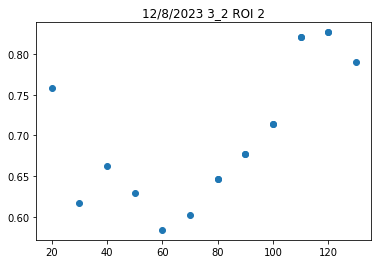

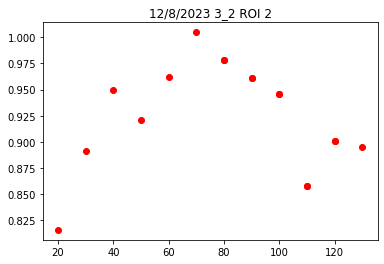

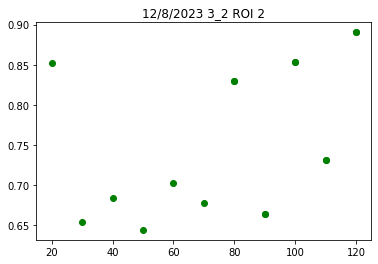

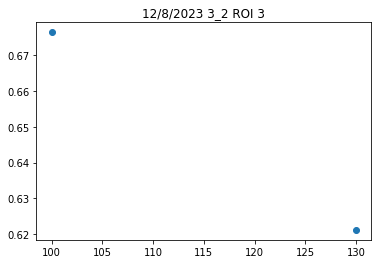

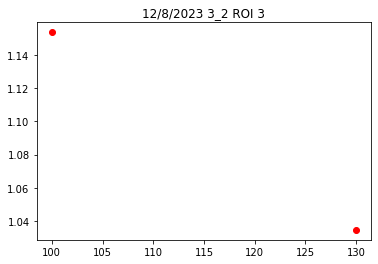

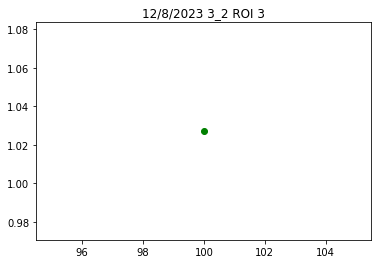

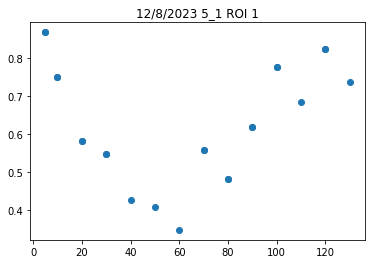

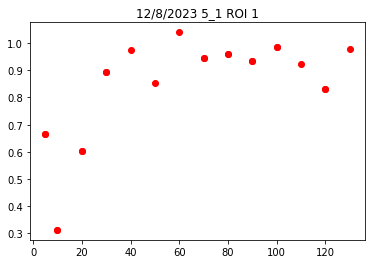

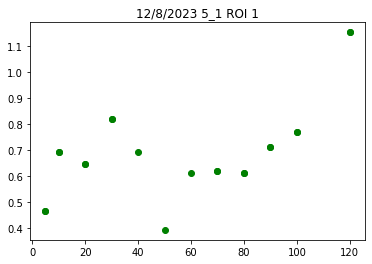

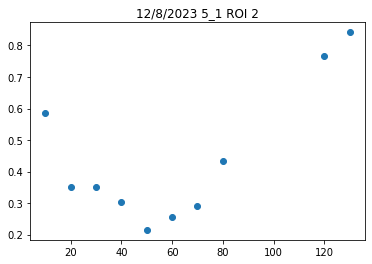

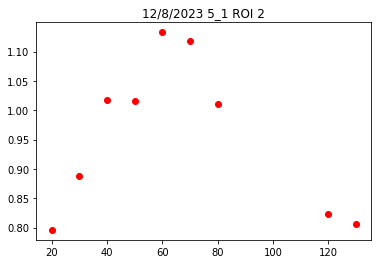

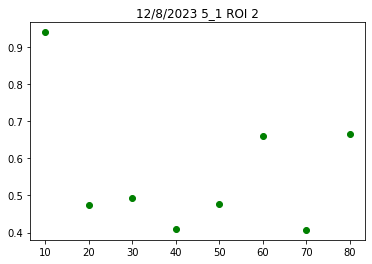

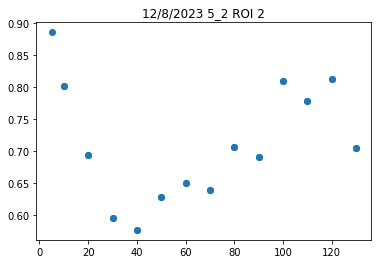

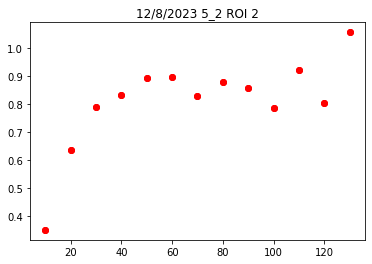

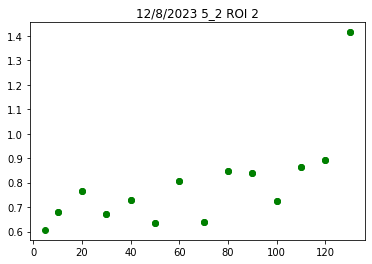

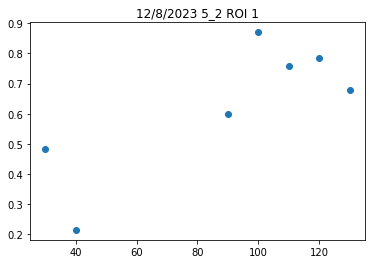

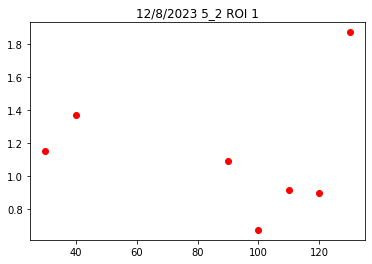

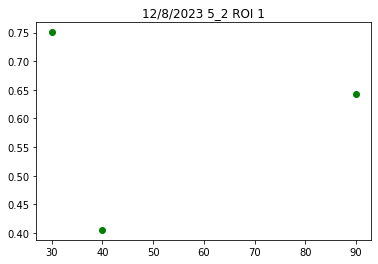

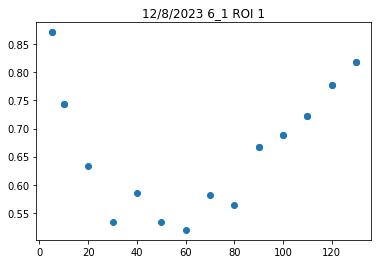

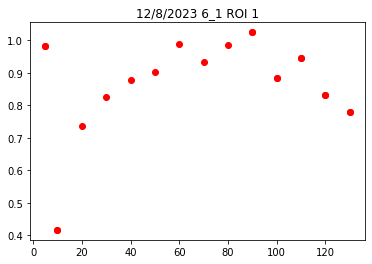

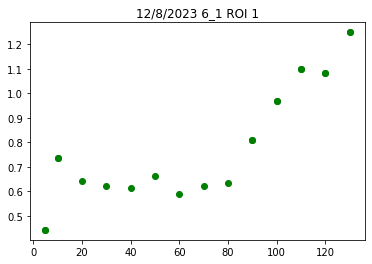

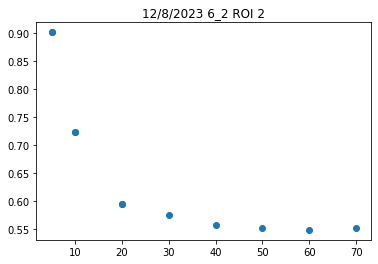

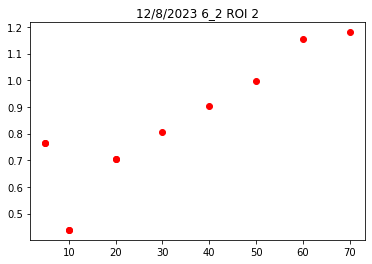

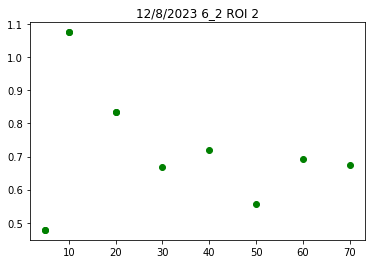

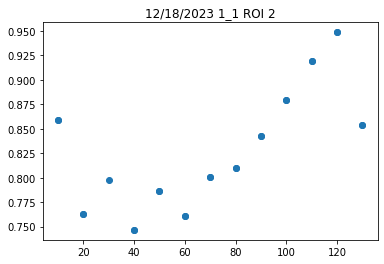

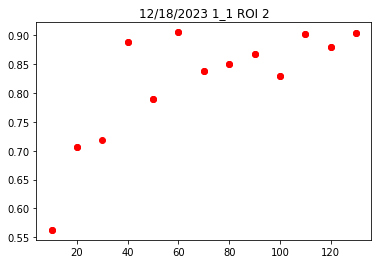

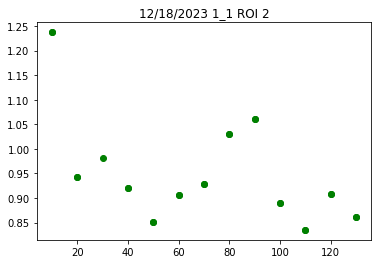

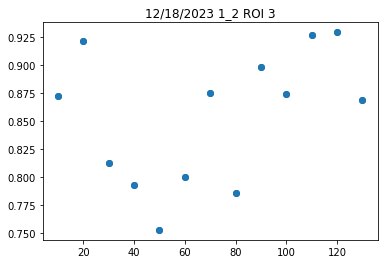

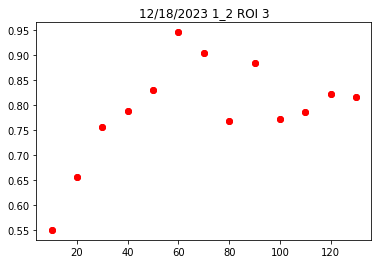

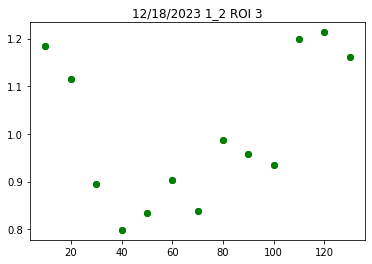

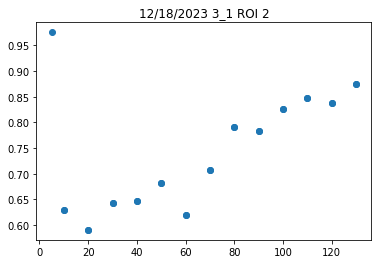

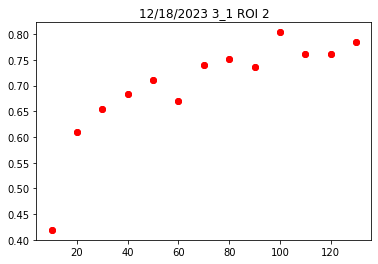

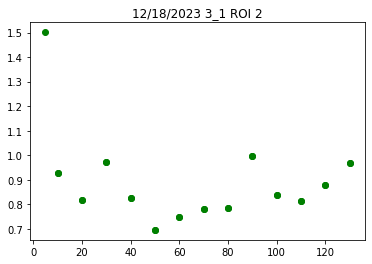

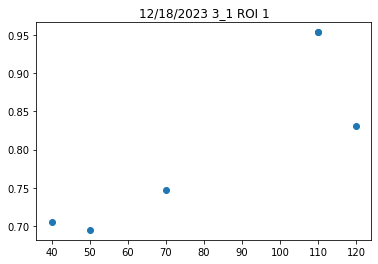

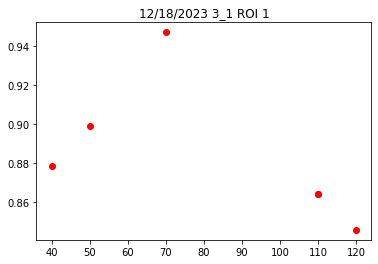

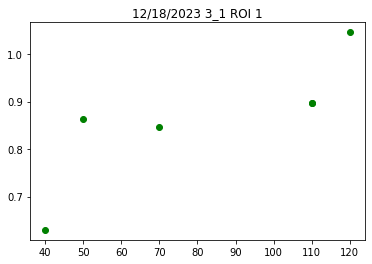

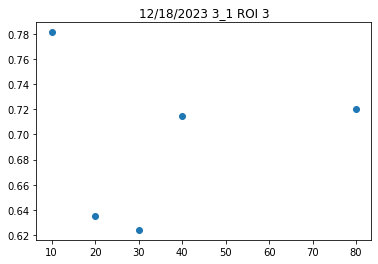

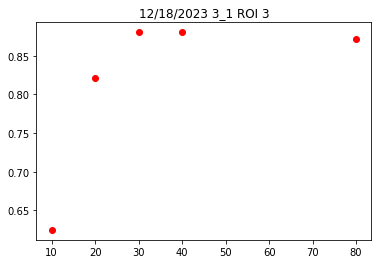

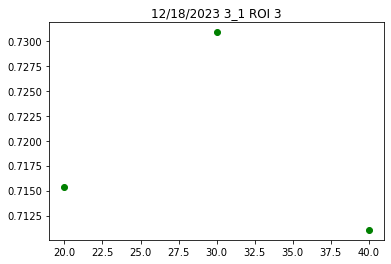

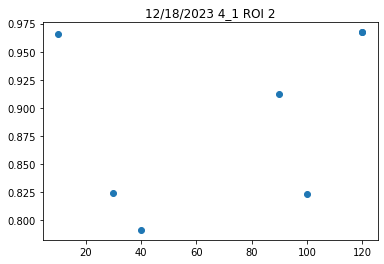

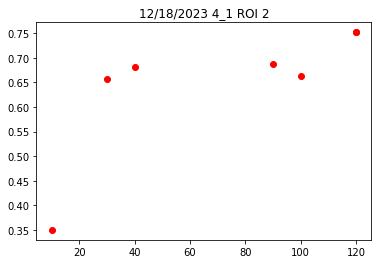

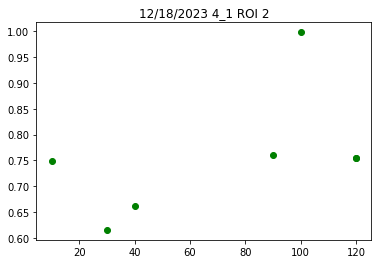

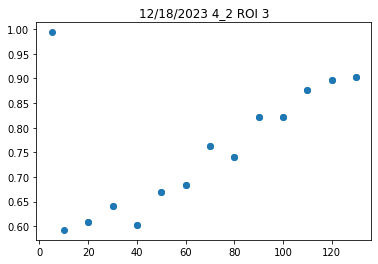

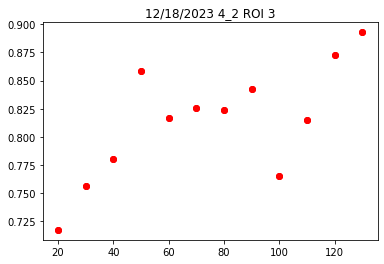

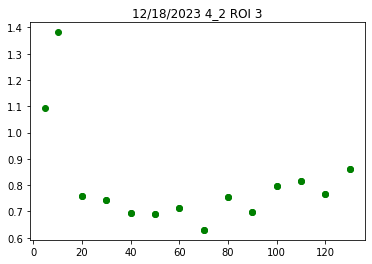

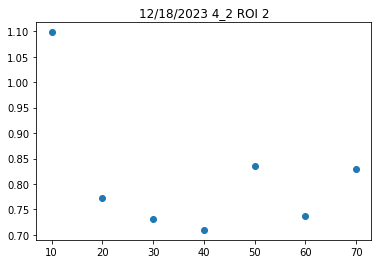

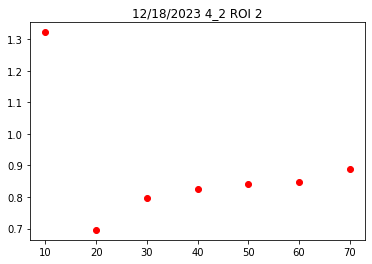

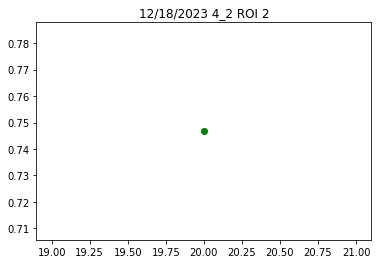

In [ ]:
# for each date, slice/loc, and ROI, plot PPR vs IPI
for date in all_snr['Date'].unique():
    pfs_date = all_snr[all_snr["Date"] == date]
    for slic_loc in pfs_date['Slice_Loc'].unique():
        pfs_sl = pfs_date[pfs_date["Slice_Loc"] == slic_loc]
        for roi in pfs_sl['ROI'].unique():
            pfs_roi = pfs_sl[pfs_sl['ROI'] == roi]
            plt.scatter(pfs_roi['IPI'], pfs_roi['PPR'])
            plt.title(date + " " + slic_loc + " ROI " + str(roi))
            plt.show()
            plt.scatter(pfs_roi['IPI'], pfs_roi['PPL'], c='r')
            plt.title(date + " " + slic_loc + " ROI " + str(roi))
            plt.show()
            plt.scatter(pfs_roi['IPI'], pfs_roi['PPHW'], c='g')
            plt.title(date + " " + slic_loc + " ROI " + str(roi))
            plt.show()

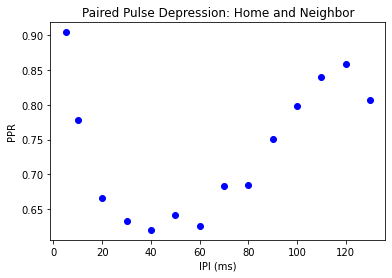

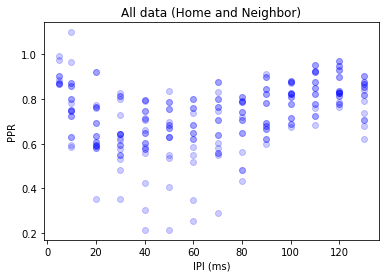

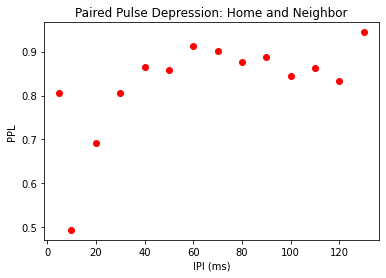

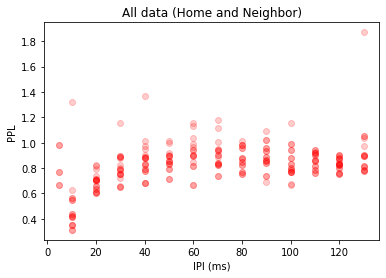

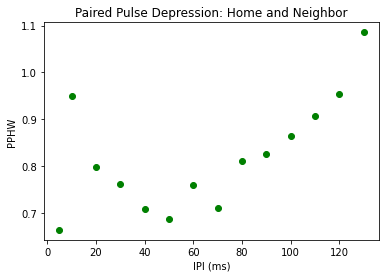

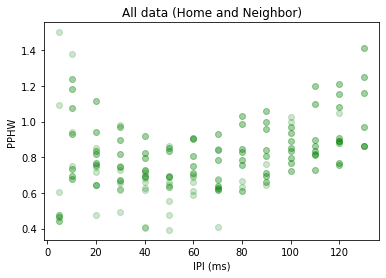

In [ ]:
# average grouping by IPI
for pp_type, color in [['PPR', 'b'], ['PPL', 'r'], ['PPHW', 'g']]:
    group_by_ipi = all_snr[['IPI', pp_type]].groupby(by=['IPI']).mean()
    group_by_ipi_std = all_snr[['IPI', pp_type]].groupby(by=['IPI']).agg(np.std)
    group_by_ipi.reset_index(inplace=True)
    
    

    # plot average PPR vs IPI
    plt.scatter(group_by_ipi['IPI'], group_by_ipi[pp_type], c=color)
    plt.title("Paired Pulse Depression: Home and Neighbor")
    plt.xlabel("IPI (ms)")
    plt.ylabel(pp_type)
    plt.show()
    plt.scatter(all_snr['IPI'], all_snr[pp_type], alpha=0.2, c=color)
    plt.xlabel("IPI (ms)")
    plt.ylabel(pp_type)
    plt.title("All data (Home and Neighbor)")
    plt.show()

     PPR
IPI     
5      9
10    16
20    16
30    15
40    15
50    14
60    14
70    15
80    15
90    17
100   17
110   15
120   18
130   14
i= 0
5
p_val for IPI 10 : 8.592956312488075e-05
p_val for IPI 20 : 4.3634307987973636e-07
p_val for IPI 30 : 4.443868994227066e-08
p_val for IPI 40 : 4.2323834171328735e-08
p_val for IPI 50 : 1.2033138132465635e-07
p_val for IPI 60 : 5.925589389078504e-07
p_val for IPI 70 : 1.9707368043477233e-06
p_val for IPI 80 : 2.1200735105992378e-06
p_val for IPI 90 : 2.4378648107467714e-05
p_val for IPI 100 : 6.744691901990688e-05
p_val for IPI 110 : 0.005038194449033619
p_val for IPI 120 : 0.06339317184712819
p_val for IPI 130 : 0.0021920655776896418
[None, '***', '***', '***', '***', '***', '***', '***', '***', '***', '***', '**', None, '**']


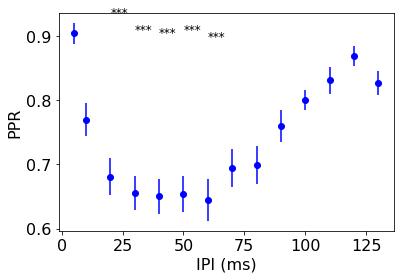

     PPR
IPI     
10     3
20     3
30     4
40     5
50     3
60     2
70     3
80     2
90     1
100    2
110    3
120    3
130    3
i= 1
110
p_val for IPI 10 : 0.3574277330932166
p_val for IPI 20 : 0.059659720767806165
p_val for IPI 30 : 0.011506795646557752
p_val for IPI 40 : 0.016499912847543093
p_val for IPI 50 : 0.12015888057420587
p_val for IPI 60 : 0.1681095415250668
p_val for IPI 70 : 0.12534825180855488
p_val for IPI 80 : 0.11765867601279524
p_val for IPI 90 : nan
p_val for IPI 100 : 0.21677654415926367
p_val for IPI 120 : 0.14233278597676785
p_val for IPI 130 : 0.06748862648604877
[None, None, '*', '*', None, None, None, None, None, None, None, None, None]


c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


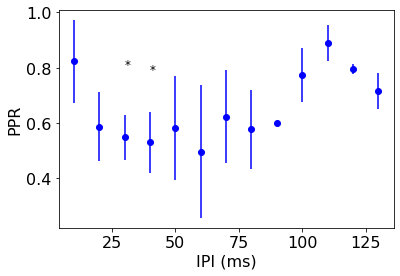

     PPL
IPI     
30    15
40    15
50    14
60    14
70    15
80    15
90    17
100   17
110   15
120   18
130   14
i= 0
30
p_val for IPI 40 : 0.9324871452328941
p_val for IPI 50 : 0.9899503454777987
p_val for IPI 60 : 0.9976851028651849
p_val for IPI 70 : 0.9980660296360082
p_val for IPI 80 : 0.9975291429097691
p_val for IPI 90 : 0.9988364974205632
p_val for IPI 100 : 0.9768451847829115
p_val for IPI 110 : 0.9982372463016405
p_val for IPI 120 : 0.9846440438522089
p_val for IPI 130 : 0.9984298255973668
[None, None, None, None, None, None, None, None, None, None, None]


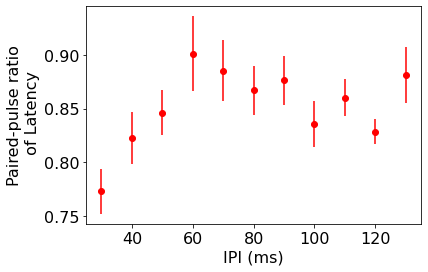

     PPL
IPI     
30     4
40     5
50     3
60     2
70     3
80     2
90     1
100    2
110    3
120    3
130    3
i= 1
30
p_val for IPI 40 : 0.6877587938440185
p_val for IPI 50 : 0.45745479333903766
p_val for IPI 60 : 0.6250362117206143
p_val for IPI 70 : 0.6935628024978111
p_val for IPI 80 : 0.5433160239383263
p_val for IPI 90 : nan
p_val for IPI 100 : 0.4794950990272257
p_val for IPI 110 : 0.2904590180072159
p_val for IPI 120 : 0.20547140311111237
p_val for IPI 130 : 0.7781250126561303
[None, None, None, None, None, None, None, None, None, None, None]


c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


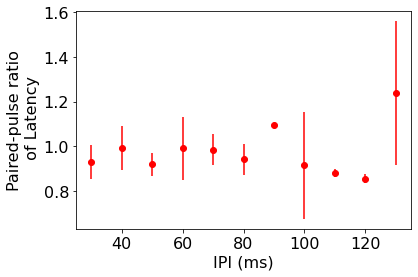

     PPHW
IPI      
30     15
40     15
50     14
60     14
70     15
80     15
90     17
100    17
110    14
120    18
130    12
i= 0
30
p_val for IPI 40 : 0.24312966004110914
p_val for IPI 50 : 0.03262265224508573
p_val for IPI 60 : 0.36942815063672085
p_val for IPI 70 : 0.09994428242427383
p_val for IPI 80 : 0.7759252374406427
p_val for IPI 90 : 0.8636447805330671
p_val for IPI 100 : 0.9576502225352671
p_val for IPI 110 : nan
p_val for IPI 120 : 0.9986470226622407
p_val for IPI 130 : nan
[None, None, '*', None, None, None, None, None, None, None, None]


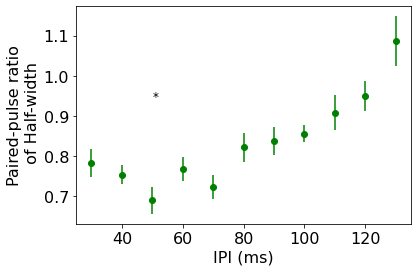

     PPHW
IPI      
30      3
40      4
50      2
60      1
70      2
80      1
90      1
100     1
110     2
120     1
130     0
i= 1
30
p_val for IPI 40 : nan
p_val for IPI 50 : nan
p_val for IPI 60 : nan
p_val for IPI 70 : nan
p_val for IPI 80 : nan
p_val for IPI 90 : nan
p_val for IPI 100 : nan
p_val for IPI 110 : nan
p_val for IPI 120 : nan
p_val for IPI 130 : nan
[None, None, None, None, None, None, None, None, None, None, None]


c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


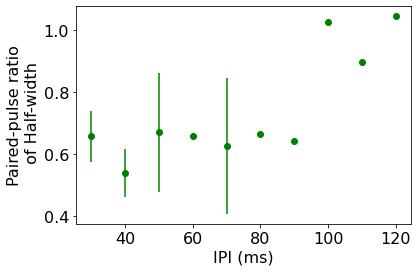

In [ ]:
# home barrel or neighboring barrel
plt.rcParams.update({'font.size': 16})

home_barrel_df = all_snr.query('`Home Barrel` == ROI')
neighbor_barrel_df = all_snr.query('`Home Barrel` != ROI')
titles = ['Home Barrel', 'Neighbor Barrel']

for pp_type, color in [['PPR', 'b'], ['PPL', 'r'], ['PPHW', 'g']]:
    i = 0
    for barrel_df in [home_barrel_df, neighbor_barrel_df]:
        
        if pp_type in ['PPL', 'PPHW']:
            barrel_df = barrel_df[barrel_df['IPI'] > 20]
        group_by_ipi = barrel_df[['IPI', pp_type]].groupby(by=['IPI']).mean()
        group_by_ipi_std = barrel_df[['IPI', pp_type]].groupby(by=['IPI']).agg(np.std) / np.sqrt(barrel_df[['IPI', pp_type]].groupby(by=['IPI']).count())
        group_by_ipi.reset_index(inplace=True)

        count_by_ipi = barrel_df[['IPI', pp_type]].groupby(by=['IPI']).count()
        print(count_by_ipi)

        # significance tests against the first IPI
        first_ipi = np.min(group_by_ipi['IPI'])
        pvals = []
        print("i=", i)
        if pp_type == 'PPR' and titles[i] == 'Neighbor Barrel':
            first_ipi = 110
        print(first_ipi)
        
        first_ipi_data = barrel_df[barrel_df['IPI'] == first_ipi][pp_type]
        for ipi in group_by_ipi['IPI']:
            if ipi == first_ipi:
                pvals.append(1)
                continue
            ipi_data = barrel_df[barrel_df['IPI'] == ipi][pp_type]
            
            # Welch's (one-sided) t-test if ipi_data is less than first_ipi_data
            t_stat, p_val = ttest_ind(ipi_data, first_ipi_data, alternative='less', equal_var=False)
            print("p_val for IPI", ipi, ":", p_val)
            pvals.append(p_val)

        def get_sig_level(x):
            if x < 0.001:
                return '***'
            if x < 0.01:
                return '**'
            if x < 0.05:
                return '*'
        significance_levels = [get_sig_level(x) for x in pvals]
        print(significance_levels)
            

        plt.scatter(group_by_ipi['IPI'], group_by_ipi[pp_type], c=color)
        plt.errorbar(group_by_ipi['IPI'], group_by_ipi[pp_type], 
                     group_by_ipi_std[pp_type], ls='none', c=color)
        y_label = pp_type
        if pp_type == 'PPL':
            y_label = "Paired-pulse ratio\n of Latency"
        if pp_type == 'PPHW':
            y_label = "Paired-pulse ratio\n of Half-width"
        # plt.title("Paired Pulse Depression in " + titles[i])
        
        # place significance levels on plot
        for j, txt in enumerate(significance_levels):
            plt.annotate(txt, (group_by_ipi['IPI'].iloc[j], min(0.95, group_by_ipi[pp_type].iloc[j] + 0.25)), fontsize=12)

        plt.xlabel("IPI (ms)")
        #plt.xticks([])
        plt.ylabel(y_label)
        plt.show()
        i += 1

In [ ]:
# home barrel or neighboring barrel
plt.rcParams.update({'font.size': 16})

home_barrel_df = all_snr.query('`Home Barrel` == ROI')
neighbor_barrel_df = all_snr.query('`Home Barrel` != ROI')
pvals = []
# significance tests: home versus neighbor
for ipi in group_by_ipi['IPI']:
    
    # one-sided t-test if ipi_data is less than first_ipi_data
    t_stat, p_val = ttest_ind(neighbor_barrel_df[neighbor_barrel_df['IPI'] == ipi]["PPR"],
                              home_barrel_df[home_barrel_df['IPI'] == ipi]["PPR"],  
                                alternative='less', 
                                equal_var=False)
    print("p_val for IPI", ipi, ":", p_val)
    pvals.append(p_val)

def get_sig_level(x):
    if x < 0.001:
        return '***'
    if x < 0.01:
        return '**'
    if x < 0.05:
        return '*'
significance_levels = [get_sig_level(x) for x in pvals]
print(significance_levels)

p_val for IPI 30 : 0.14343921066810467
p_val for IPI 40 : 0.17318437451795382
p_val for IPI 50 : 0.36947977978831437
p_val for IPI 60 : 0.323582422179997
p_val for IPI 70 : 0.3553153398150594
p_val for IPI 80 : 0.27417524272085814
p_val for IPI 90 : nan
p_val for IPI 100 : 0.4133904288679881
p_val for IPI 110 : 0.760454649545083
p_val for IPI 120 : 0.014189138202098148
p_val for IPI 

c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\Anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


130 : 0.1129068178506545
[None, None, None, None, None, None, None, None, None, '*', None]


116
85


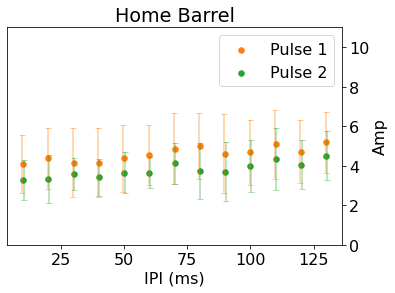

(13,) (13,) (13,) (13,)


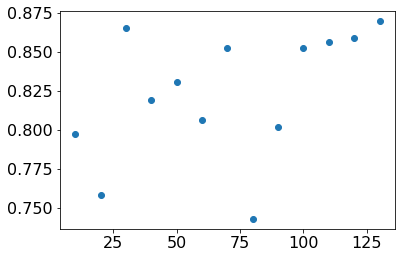

116
85


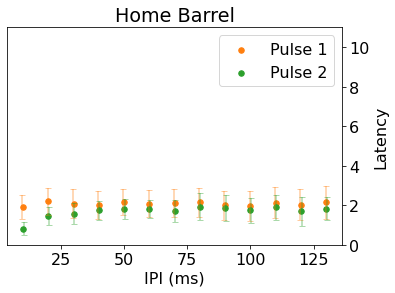

(13,) (13,) (13,) (13,)


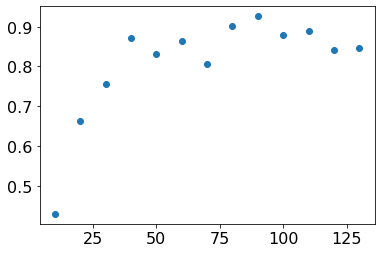

116
85


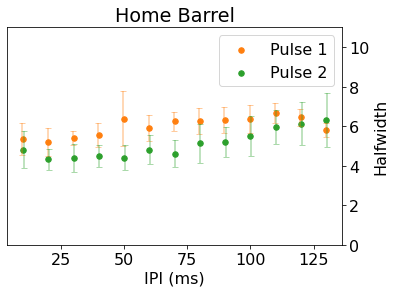

(13,) (13,) (13,) (13,)


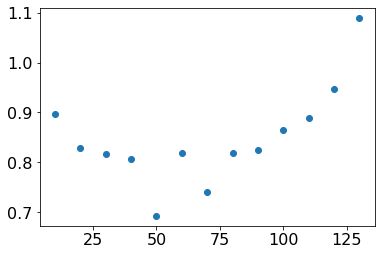

26
11


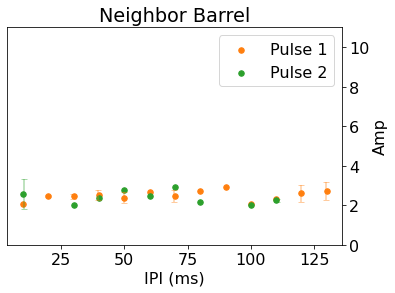

(13,) (13,) (9,) (13,)


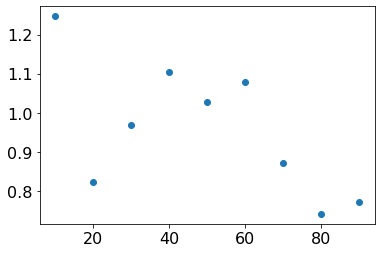

26
11


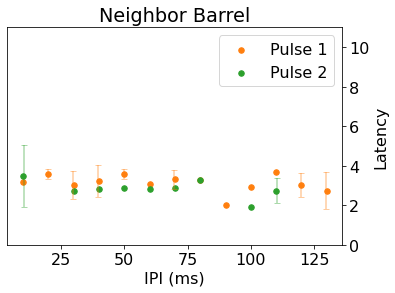

(13,) (13,) (9,) (13,)


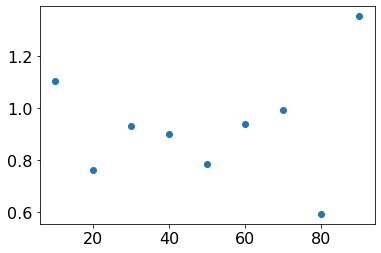

26
11


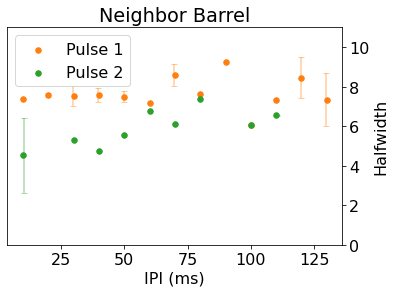

(13,) (13,) (9,) (13,)


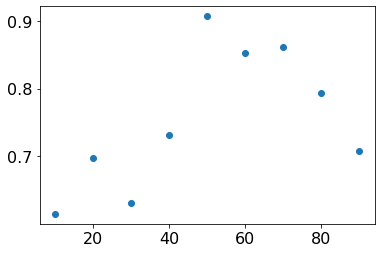

In [ ]:
# check for pulse 1 vs pulse 2 changes in latency or halfwidth
alpha = 0.5
should_group_by_ipi = True
if should_group_by_ipi:
    alpha = 1
ppr_snr = all_snr.query('PPR > 0')
ppr_snr = ppr_snr.query('PPR < 2')
pulse1_df = ppr_snr.query('Pulse == 1')
pulse2_df = ppr_snr.query('Pulse == 2')
titles = ['Pulse 1', 'Pulse 2']
pulse_colors = ['tab:orange', 'tab:green']

for barrel in ['Home Barrel', 'Neighbor Barrel']:
    for met_type, color in [['Amp', 'b'], ['Latency', 'r'], ['Halfwidth', 'g']]:
        i = 0
        end1, end2 = None, None
        for pulse_df in [pulse1_df, pulse2_df]:
            total_n = len(pulse_df['IPI'])
            if barrel == 'Home Barrel':
                pulse_df = pulse_df.query('`Home Barrel` == ROI')
            else:
                pulse_df = pulse_df.query('`Home Barrel` != ROI')
            pulse_df = pulse_df[pulse_df['IPI'] > 5]
            subset_n = len(pulse_df['IPI'])
            print(len(pulse_df['IPI']))
            if should_group_by_ipi:
                pulse_df_std = pulse_df[['IPI', met_type]].groupby(by=['IPI']).agg(np.std)
                pulse_df = pulse_df[['IPI', met_type]].groupby(by=['IPI']).mean()
                pulse_df.reset_index(inplace=True)
                plt.errorbar(pulse_df['IPI'] + i * 0.5 - 0.25, pulse_df[met_type], 
                            pulse_df_std[met_type], ls='none', c=pulse_colors[i], capsize=3, alpha=0.4)
            if end1 is None:
                end1 = pulse_df
            else:
                end2 = pulse_df
            plt.scatter(pulse_df['IPI'], pulse_df[met_type], alpha=alpha,
                        s=30,
                        color=pulse_colors[i],
                         label=titles[i] )
            i += 1
        plt.title(barrel)
        plt.xlabel("IPI (ms)")
        plt.ylabel(met_type)
        plt.ylim(0, 11)
        plt.legend()
        plt.gca().yaxis.set_label_position("right")
        plt.gca().yaxis.tick_right()
        
        plt.show()
        ppr = end2[met_type] / end1[met_type]
        print(ppr.shape, end1[met_type].shape, end2['IPI'].shape, end1['IPI'].shape)
        plt.scatter(end1['IPI'], ppr)
        plt.show()


     IPI       Amp
0     20  1.047670
1     30  1.158740
2     40  1.122380
3     50  1.257990
4     60  1.325230
..   ...       ...
873   50  0.346318
874   90  0.334420
875   10  0.256225
876   30  0.281396
877   20  0.373637

[863 rows x 2 columns]
     IPI       Amp
0     20  0.747929
1     30  0.530139
2     40  0.553891
3     50  0.463109
4     60  0.404570
..   ...       ...
873   50  0.344336
874   90  0.358232
875   10  0.372740
876   30  0.483628
877   20  0.490738

[863 rows x 2 columns]


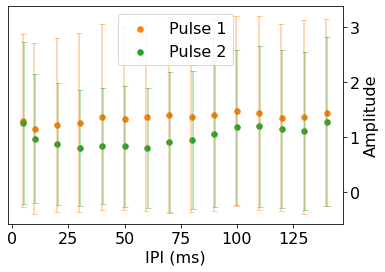

In [ ]:
# check for pulse 1 vs pulse 2 changes in latency or halfwidth
alpha = 0.2
titles = ['Pulse 1', 'Pulse 2']
pulse_colors = ['tab:orange', 'tab:green']
should_group_by_ipi = True
i = 0
if should_group_by_ipi:
    alpha = 1
for amp in [amps1, amps2]:

    if should_group_by_ipi:
        pulse_df = pd.DataFrame({'IPI': ipis, 'Amp': amp})
        pulse_df = pulse_df[pulse_df['IPI'] <150]
        print(pulse_df)
        pulse_df_std = pulse_df[['IPI', 'Amp']].groupby(by=['IPI']).agg(np.std)
        pulse_df = pulse_df[['IPI', 'Amp']].groupby(by=['IPI']).mean()
        pulse_df.reset_index(inplace=True)
        plt.errorbar(pulse_df['IPI'] + i * 0.5 - 0.25, pulse_df['Amp'], 
                    pulse_df_std['Amp'], ls='none', c=pulse_colors[i], 
                    capsize=3, alpha=0.4)

    plt.scatter(pulse_df['IPI'], pulse_df['Amp'], alpha=alpha,
                s=30,
                color=pulse_colors[i],
                    label=titles[i] )
    i += 1
plt.xlabel("IPI (ms)")
plt.ylabel('Amplitude')
plt.legend()
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()

plt.show()

In [ ]:
print(np.std(amps1), np.std(amps2))

1.6905723984998349 1.3008713295249743


In [ ]:
# autoPhotoZ to save amplitude arrays for each measure window and 
# baseline correction to create PPR maps
def get_amp_array_filename(subdir, slic_loc_id, ipi, pulse):
    return subdir + "/" + "ampArray_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(pulse) + ".dat"

overwrite_amp_arrays = False
select_amp_bkg = False
for subdir in data_map:
    aPhz = AutoPhotoZ(data_dir=subdir)
    if not select_amp_bkg and enable_photoZ_interact:
        aPhz.select_MaxAmp_array()
    print(subdir)
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            ipi_file = data_map[subdir][slic_id][loc_id]['shuffle_file']
            with open(ipi_file, 'r') as f:
                lines = f.readlines() 
            ipi_order = [int(x) for x in lines]

            # open zda files in order
            i_ipi = -1
            for zda_file in data_map[subdir][slic_id][loc_id]['zda_files']:

                i_ipi += 1
                try:
                    ipi = ipi_order[i_ipi]
                except Exception as e:
                    print(e)
                    print("Not enough IPIs for how many recordings we have! Last IPI:", ipi, "Check", subdir)
                print(slic_id, loc_id, "IPI:", ipi, "ms for recording", zda_file.split("/")[-1])
                
                # check if all amp arrays are already saved for this recording/IPI
                all_saved = True
                for i_pulse in [1, 2]:
                    amp_array_filename = get_amp_array_filename(subdir, slic_loc_id, ipi, i_pulse)
                    if not os.path.exists(amp_array_filename):
                        print("Missing", amp_array_filename)
                        all_saved = False
                        break
                if overwrite_amp_arrays:
                    all_saved = False

                if enable_photoZ_interact and not all_saved:
                    aPhz.open_zda_file(zda_file)

                for i_pulse in [1, 2]:
                    amp_array_filename = get_amp_array_filename(subdir, slic_loc_id, ipi, i_pulse)
                    if not os.path.exists(amp_array_filename) or overwrite_amp_arrays:
                        if enable_photoZ_interact and not all_saved:
                            measure_window_start = 96 + (i_pulse - 1) * ipi * 2
                            aPhz.set_measure_window(measure_window_start, None)

                            # change polynomial skip window too to match measure window
                            aPhz.set_polynomial_skip_window(measure_window_start)

                        # take Amplitude array from PhotoZ
                        if enable_photoZ_interact and not all_saved:
                            aPhz.save_background(filename=amp_array_filename)
                    else:
                        if not all_saved:
                            time.sleep(5)

                    if ipi not in data_map[subdir][slic_id][loc_id]:
                        data_map[subdir][slic_id][loc_id][ipi] = {}
                    if i_pulse not in data_map[subdir][slic_id][loc_id][ipi]:
                        data_map[subdir][slic_id][loc_id][ipi][i_pulse] = {}
                    data_map[subdir][slic_id][loc_id][ipi][i_pulse]['amp_array'] = amp_array_filename
                    
            if i_ipi < len(ipi_order) - 1:
                print("Not enough recordings for how many IPIs we have! Last IPI:", ipi, "Check", subdir)
                        

P:/John/analyzed_archived/scnn1a-tg3-cre/PPR checkpoints/scnn1a-ppr/12-08-23
3 2 IPI: 10 ms for recording 03_02_02.zda
3 2 IPI: 20 ms for recording 03_02_03.zda
3 2 IPI: 30 ms for recording 03_02_04.zda
3 2 IPI: 40 ms for recording 03_02_05.zda
3 2 IPI: 50 ms for recording 03_02_06.zda
3 2 IPI: 60 ms for recording 03_02_07.zda
3 2 IPI: 70 ms for recording 03_02_08.zda
3 2 IPI: 80 ms for recording 03_02_09.zda
3 2 IPI: 90 ms for recording 03_02_10.zda
3 2 IPI: 100 ms for recording 03_02_11.zda
3 2 IPI: 110 ms for recording 03_02_12.zda
3 2 IPI: 120 ms for recording 03_02_13.zda
3 2 IPI: 130 ms for recording 03_02_14.zda
3 2 IPI: 140 ms for recording 03_02_15.zda
3 2 IPI: 150 ms for recording 03_02_16.zda
3 2 IPI: 5 ms for recording 03_02_17.zda
4 1 IPI: 5 ms for recording 04_01_01.zda
4 1 IPI: 10 ms for recording 04_01_02.zda
4 1 IPI: 20 ms for recording 04_01_03.zda
4 1 IPI: 30 ms for recording 04_01_04.zda
4 1 IPI: 40 ms for recording 04_01_05.zda
4 1 IPI: 50 ms for recording 04_01_06

In [ ]:
# use amp arrays of both pulses to create PPR maps of different IPIs of the recordings 
def read_dat_arr_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Value'])
    data_arr = np.array(data_arr['Value']).reshape((80, 80))
    return data_arr

area_by_ipi = {'ipi': [], 'area': []}
ppr_hist = []
pphw_hist = []
ppl_hist = []
# load in amp array files into dataframe for each IPI
for subdir in data_map:
    
    # extract date from subdir so we can look up metadata from master_df
    date = subdir.split("/")[-1].split('-')
    date = [int(x) for x in date]
    date[-1] += 2000
    date = "/".join([str(x) for x in date])
    metadata_date = master_df[master_df['Date'] == date]
    
    for slic_id in data_map[subdir]:
        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)
            metadata = metadata_date[metadata_date['Slice_Loc'] == slic_loc_id]
            medial_dir = metadata['Medial Dir'].item()
            stim_layer = metadata['Stim Layer'].item()
            caudal_rostral = metadata['Caudal/Rostral'].item()
            home_barrel = int(metadata['Home Barrel'].item())

            for ipi in data_map[subdir][slic_id][loc_id]:

                if type(ipi) == str:
                    continue
                
                # load amp files as numpy arrays using np.loadtxt
                amp_arr1 = get_amp_array_filename(subdir, slic_loc_id, ipi, 1)
                amp_arr2 = get_amp_array_filename(subdir, slic_loc_id, ipi, 2)
                amp_arr1 = read_dat_arr_file(amp_arr1)
                amp_arr2 = read_dat_arr_file(amp_arr2)
                ppr_map = amp_arr2 / amp_arr1

                area1 = np.sum(amp_arr1 > amp_cutoff)
                area2 = np.sum(amp_arr2 > amp_cutoff)
                if area1 > 0:
                    area_ratio = area2 / area1
                    area_by_ipi['area'].append(area_ratio)
                    area_by_ipi['ipi'].append(ipi)

                ppr_map[amp_arr1 < amp_cutoff] = 0
                '''if np.sum(ppr_map) > 0:
                    fig, axes = plt.subplots(1, 2)
                    axes[0].imshow(ppr_map, cmap='viridis')
                    axes[1].imshow(ppr_map > 1, cmap='viridis')
                    plt.show()
                    #print(np.max(ppr_map), np.min(ppr_map))'''

                # build histogram of PPR values for pixels above cutoff
                for i in range(amp_arr1.shape[0]):
                    for j in range(amp_arr1.shape[1]):
                        if amp_arr1[i, j] > amp_cutoff * 3 and 0 < ppr_map[i, j] < 2 and amp_arr2[i, j] != amp_arr1[i, j]:
                            ppr_hist.append(ppr_map[i, j])


<ipython-input-25-3df44ed10901>:45: RuntimeWarning: divide by zero encountered in divide
  ppr_map = amp_arr2 / amp_arr1
<ipython-input-25-3df44ed10901>:45: RuntimeWarning: invalid value encountered in divide
  ppr_map = amp_arr2 / amp_arr1


            params     sigma
mu1       0.616229  0.004194
sigma1    0.074451  0.003482
A1      347.639859  8.823716
mu2       0.826017  0.003261
sigma2    0.079602  0.002790
A2      468.433657  8.102366


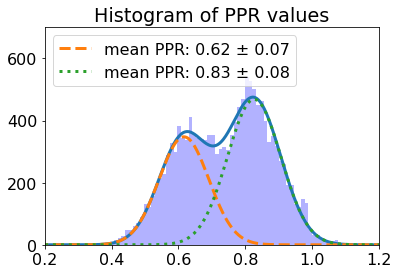

In [ ]:
# plot histogram of PPR values
y,x,_=plt.hist(ppr_hist, bins=100, color='b', alpha=0.3)
plt.title("Histogram of PPR values")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

#data generation
np.random.seed(123)
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

#x, y inputs can be lists or 1D numpy arrays

def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

expected = (0.6, .2, 250, 0.8, .2, 125)
params, cov = curve_fit(bimodal, x, y, expected)
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)
#plot combined...
plt.plot(x_fit, bimodal(x_fit, *params), color='tab:blue', lw=3)
#...and individual Gauss curves
plt.plot(x_fit, gauss(x_fit, *params[:3]), 
         color='tab:orange', lw=3, ls="--", label='mean PPR: 0.62 ± 0.07' )
plt.plot(x_fit, gauss(x_fit, *params[3:]), 
         color='tab:green', lw=3, ls=":", label='mean PPR: 0.83 ± 0.08')
#and the original data points if no histogram has been created before
#plt.scatter(x, y, marker="X", color="black", label="original data")
plt.legend(loc = 'upper left')
plt.ylim(0, 700)
plt.xlim(0.2, 1.2)
print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
plt.show() 